In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image

# Hyperparameters

In [2]:
image_size = 64
batch_size = 265
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess
latent_size = 128
lr = 0.00025
epochs = 1000

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')
device

device(type='cuda', index=1)

In [4]:
sample_dir = 'generated_lab_week05'
os.makedirs(sample_dir, exist_ok=True)

# Helpers

In [5]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [7]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

# Dataset prepair

In [8]:
DATA_DIR = '/home/mh731nk/_data/experiments_tmp/data/celeba_dataset/img_align_celeba'

In [9]:
train_ds = ImageFolder(root=DATA_DIR, 
            transform=T.Compose([T.Resize(image_size),
                                T.CenterCrop(image_size), # pick central square crop of it
                                T.ToTensor(),
                                T.Normalize(*stats)        # normalize => -1 to 1                               
                            ]))



In [10]:

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores

In [11]:
# helper functions to denormalize the image tensors and display some sample images from a training batch. 
# In future for helping train could be calculated zero centered nomralization per channel :)
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

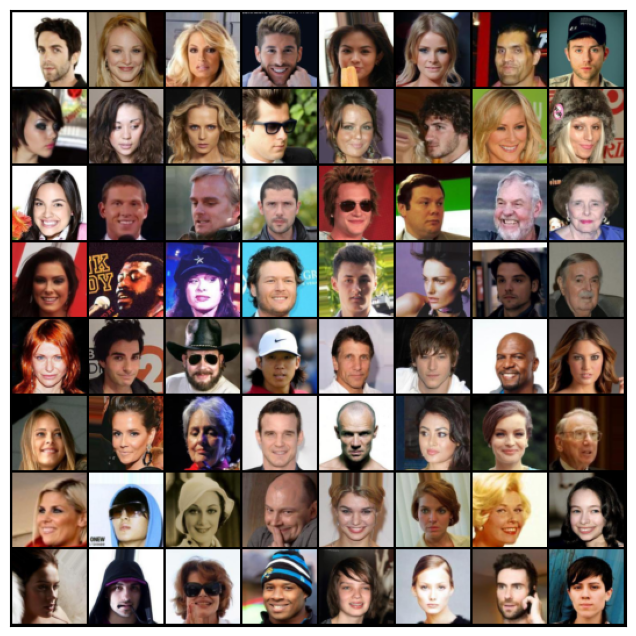

In [13]:
show_batch(train_dl) # original data looks "cudne pokrucene"

In [14]:
# move to GPU
train_dl = DeviceDataLoader(train_dl, device)

# Models

## Generator

In [15]:
latent_size

128

In [16]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, input):
        x = self.relu(self.bn1(self.conv1(input)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.tanh(self.conv5(x))
        return x


## Discriminator

In [17]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Define the leaky ReLU activation
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)

        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        # Define the forward pass
        x = self.leaky_relu(self.bn1(self.conv1(input)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.leaky_relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = self.flatten(x)
        x = self.sigmoid(x)
        return x




In [18]:
generator = Generator(latent_size)
discriminator = Discriminator()

In [19]:
# from torchsummary import summary
# summary(generator, (128,1,1))
# print(generator)

## Check out

torch.Size([265, 3, 64, 64])


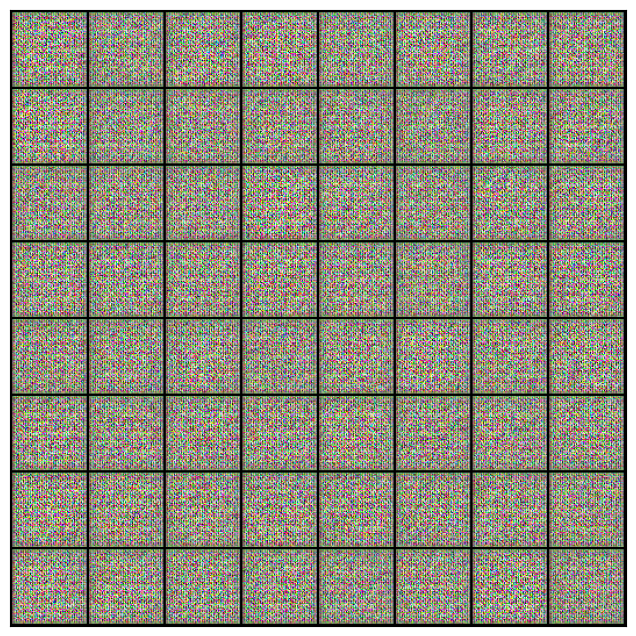

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device) 
discriminator = to_device(discriminator, device)
lr

0.00025

In [22]:

def train(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for idx, epoch in enumerate(range(0,epochs)):
    print(f"epoch {idx} start")
    for real_images, _ in tqdm(train_dl):


        ### Train discriminator
        # Clear discriminator gradients
        opt_d.zero_grad()

        # Pass real images through  discriminator
        real_preds = discriminator(real_images)
        real_targets = torch.ones(real_images.size(0), 1, device=device)
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        real_score = torch.mean(real_preds).item()

        # Generate fake images
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(latent)

        # Pass Fake images through discriminator
        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = discriminator(fake_images)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        fake_score = torch.mean(fake_preds).item()

        # Update discriminator weights
        loss_d = real_loss + fake_loss
        loss_d.backward()
        opt_d.step()

        # loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)




        ### Train generator
        # Clear generator gradients
        opt_g.zero_grad()

        # Generate fake images
        latent = torch.randn(batch_size, latent_size, 1,1, device=device)
        fake_images = generator(latent)

        # Try to fool the discriminator
        preds = discriminator(fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = F.binary_cross_entropy(preds, targets)

        # Update generator 
        loss_g.backward()
        opt_g.step()



    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d.item())
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

## Test latent space
We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [24]:
epochs

1000

In [25]:
history = train(epochs, lr)

epoch 0 start


100%|██████████| 765/765 [00:40<00:00, 18.74it/s]


Epoch [1/1000], loss_g: 5.0000, loss_d: 0.5937, real_score: 0.8792, fake_score: 0.3359
Saving generated=images-0001.png
epoch 1 start


 43%|████▎     | 327/765 [00:17<00:23, 18.57it/s]

In [ ]:
idx

NameError: name 'idx' is not defined

In [ ]:
!nvidia-smi

Wed Apr  3 16:01:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   37C    P8              19W / 230W |    208MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--